In [61]:
import os
if "x_perceiver" not in os.listdir():
    os.chdir("/home/kh701/pycharm/healnet/")
import torch
from torch import nn
import multiprocessing
import torchvision
import numpy as np
import torchvision.transforms as transforms
import einops
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from healnet.models.explainer import Explainer
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

from healnet.utils import Config, flatten_config
from healnet.etl import TCGADataset
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

    
%reload_ext autoreload
%autoreload 2

## Import data

In [62]:
# get dataloaders
config = Config("config/main_gpu.yml").read()
config = flatten_config(config) # TODO - refactor to other 

blca = TCGADataset(
    dataset="blca", 
    config=config, 
    level=2, 
    sources=["omic"]
)

brca = TCGADataset(
    dataset="brca", 
    config=config, 
    level=2, 
    sources=["omic"]
)



Filled 0 missing values with mean
Missing values per feature: 
 Series([], dtype: int64)
Slides available: 436
Omic available: 437
Overlap: 436
Filtering out 1 samples for which there are no omic data available
Dataloader initialised for blca dataset
Dataset: BLCA
Molecular data shape: (436, 2191)
Molecular/Slide match: 436/436
Slide level count: 4
Slide level dimensions: ((79968, 79653), (19992, 19913), (4998, 4978), (2499, 2489))
Slide resize dimensions: w: 1024, h: 1024
Sources selected: ['omic']
Censored share: 0.539
Survival_bin_sizes: {0: 72, 1: 83, 2: 109, 3: 172}
Filled 0 missing values with mean
Missing values per feature: 
 Series([], dtype: int64)
Slides available: 1019
Omic available: 1022
Overlap: 1019
Filtering out 3 samples for which there are no omic data available
Dataloader initialised for brca dataset
Dataset: BRCA
Molecular data shape: (1019, 2922)
Molecular/Slide match: 1019/1019
Slide level count: 3
Slide level dimensions: ((35855, 34985), (8963, 8746), (2240, 218

In [63]:
# get tabular data
blca_loader = DataLoader(
    blca, 
    batch_size=1, 
    shuffle=True, 
    num_workers=multiprocessing.cpu_count()-1
)
[sample], censorship, event_time, y_disc = next(iter(blca_loader))

In [64]:
sample.shape

torch.Size([1, 1, 2183])

## Tabular self-supervised pre-training

To start with, we want to build and encoder-decoder model which trains a cross-attention unit as the encoder, which can later on be deployed in the iterative model. We then want to benchmark the performance with pan-cancer pre-training vs. without pre-training. 

In [123]:
from healnet.models.healnet import PreNorm, default, temperature_softmax, exists
from einops import rearrange, repeat
from torch import nn, einsum


# class Attention(nn.Module):
#     def __init__(self, query_dim, context_dim = None, heads = 8, dim_head = 64, dropout = 0.):
#         super().__init__()
#         inner_dim = dim_head * heads
#         context_dim = default(context_dim, query_dim) # self-attention if context is not provided
#         
#         self.scale = dim_head ** -0.5
#         self.heads = heads
# 
#         self.to_q = nn.Linear(query_dim, inner_dim, bias = False)
#         self.to_kv = nn.Linear(context_dim, inner_dim * 2, bias = False)
# 
#         self.dropout = nn.Dropout(dropout)
#         # add leaky relu
#         self.to_out = nn.Sequential(
#             nn.Linear(inner_dim, context_dim),
#             nn.LeakyReLU(negative_slope=1e-2)
#         )
# 
#         self.attn_weights = None
#         # self._init_weights()
# 
#     def _init_weights(self):
#     # Use He initialization for Linear layers
#         for m in self.modules():
#             if isinstance(m, nn.Linear):
#                 nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
#                 # Initialize bias to zero if there's any
#                 if m.bias is not None:
#                     nn.init.zeros_(m.bias)
# 
#     def forward(self, x, context = None, mask = None):
#         h = self.heads
#         print(x.shape)
#         print(context.shape)
# 
#         q = self.to_q(x)
#         context = default(context, x)
#         k, v = self.to_kv(context).chunk(2, dim = -1)
# 
#         q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> (b h) n d', h = h), (q, k, v))
# 
#         sim = einsum('b i d, b j d -> b i j', q, k) * self.scale
# 
#         if exists(mask):
#             mask = rearrange(mask, 'b ... -> b (...)')
#             max_neg_value = -torch.finfo(sim.dtype).max
#             mask = repeat(mask, 'b j -> (b h) () j', h = h)
#             sim.masked_fill_(~mask, max_neg_value)
# 
#         # attention, what we cannot get enough of
#         # attn = sim.softmax(dim = -1)
#         attn = temperature_softmax(sim, temperature=0.5, dim=-1)
#         self.attn_weights = attn
#         print("Attn weights", self.attn_weights.shape)
#         attn = self.dropout(attn)
# 
# 
#         out = einsum('b i j, b j d -> b i d', attn, v)
#         out = rearrange(out, '(b h) n d -> b n (h d)', h = h)
#         out = self.to_out(out)
#         return out

In [209]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LatentCrossAttention(nn.Module):
    """
    Module which takes in a query tensor and a context tensor, and returns an updated context tensor.
    """
    def __init__(self, query_dim=1, latent_dim=32):
        super(LatentCrossAttention, self).__init__()

        # Weight matrices for projecting query and context (key)
        self.w_q = nn.Linear(query_dim, latent_dim, bias=False)  # Linear layer will act as our transformation matrix for Q
        self.w_c = nn.Linear(latent_dim, latent_dim, bias=False)    # Transformation matrix for K (context)

    def forward(self, query, context):
        query = einops.rearrange(query, "b c d -> b d c")
        # Linear projections of query and context
        q_proj = self.w_q(query)  # [b, 2189, 32]
        k_proj = self.w_c(context)  # [b, 256, 32]

        # Calculating attention scores
        S = torch.bmm(q_proj, k_proj.transpose(1, 2))  # [b, 2189, 256]

        # Summing over the second dimension to get the required size
        S_mean = torch.mean(S, dim=-1)  # [b, 2189]

        # Calculating attention weights
        attn = F.softmax(S_mean, dim=-1)  # [b, 2189]

        # Compute the attention-weighted sum of q_proj
        weighted_q_proj = torch.sum(attn.unsqueeze(-1) * q_proj, dim=1, keepdim=True)  # [b, 1, 32]

        # Adding the update to the original context to get the updated context
        context_prime = F.softmax(context + (weighted_q_proj * k_proj), dim=-1)

        # element-wise (hadamard) product
        query_prime = attn.unsqueeze(-1) * query  # [b, 2189, 1]

        self.attn_weights = attn
        self.query_prime = query_prime

        return context_prime

# Test case
b = 10
# tabular
channel_dims = 2189
input_channels = 1 # just one channel for tabular
num_latents = 256
latent_dim = 32
# latent_dim
query = torch.randn(b, channel_dims, input_channels)
context = torch.randn(b, num_latents, latent_dim)

attention_module = LatentCrossAttention(query_dim=input_channels, latent_dim=latent_dim)
context_prime = attention_module(query, context)

# print(attention_weights.shape)  # Expected: torch.Size([64, 2189])
# print(query_prime.shape)
print(context_prime.shape)


# latent_update = LatentUpdate()
# context_prime = latent_update(context, query_prime)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x2189 and 1x32)

In [341]:
class AttentionUpdate(nn.Module):
    def __init__(self, query_dim, latent_dim = None, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head * heads
        context_dim = default(latent_dim, query_dim)

        self.scale = dim_head ** -0.5
        self.heads = heads
        self.latent_dim = latent_dim

        self.to_q = nn.Linear(query_dim, inner_dim, bias = False)
        self.to_kv = nn.Linear(context_dim, inner_dim * 2, bias = False)

        self.dropout = nn.Dropout(dropout)

        self.attn_weights = None
        # self._init_weights()

    def _init_weights(self):
    # Use He initialization for Linear layers
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                # Initialize bias to zero if there's any
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, context, x, mask = None):
        h = self.heads
        # x = einops.rearrange(x, "b d c -> b c d")

        q = self.to_q(x)
        context = default(context, x)
        k, v = self.to_kv(context).chunk(2, dim = -1)

        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> (b h) n d', h = h), (q, k, v))
        print(q.shape, k.shape, v.shape) 

        sim = einsum('b i d, b j d -> b i j', q, k) * self.scale

        if exists(mask):
            mask = rearrange(mask, 'b ... -> b (...)')
            max_neg_value = -torch.finfo(sim.dtype).max
            mask = repeat(mask, 'b j -> (b h) () j', h = h)
            sim.masked_fill_(~mask, max_neg_value)

        # attention, what we cannot get enough of
        # attn = sim.softmax(dim = -1)
        attn = temperature_softmax(sim, temperature=0.5, dim=-1)
        attn = einops.rearrange(attn, '(b h) n j -> b h n j', h=h)
        self.attn_weights = attn
        attn = self.dropout(attn)
        attn = attn.mean(dim=-1).mean(dim=1)

        nn.LeakyReLU(negative_slope=1e-2)
        to_out = nn.Sequential(
            nn.Linear(attn.shape[1], self.latent_dim),
            nn.LeakyReLU(negative_slope=1e-2))
        # to_out.to("cuda")

        out = to_out(attn)
        # element-wise product
        out = einsum('b d, b i d -> b i d', out, context)
        return out

b = 10 
# tabular
channel_dims = 2189
input_channels = 1 # just one channel for tabular
num_latents = 256
latent_dim = 62
latent = torch.randn(b, num_latents, latent_dim)
query = torch.randn(b, input_channels, channel_dims)

print(input_channels, latent_dim)
attention_module = AttentionUpdate(query_dim=channel_dims, latent_dim=latent_dim, heads=8, dim_head=32, dropout=0.1)
out = attention_module(context=latent, x=query)
out.shape

1 62
torch.Size([80, 1, 32]) torch.Size([80, 256, 32]) torch.Size([80, 256, 32])


torch.Size([10, 256, 62])

In [299]:
query.shape

torch.Size([10, 2189, 1])

In [240]:
a = torch.randn(10, 2189, 32)
b = torch.randn(10, 256, 32)
# expand dim
a = einops.repeat(a, "b n d -> b n d j", j=1)
b = einops.repeat(b, "b n d -> b n d j", j=2189)

# torch.bmm(a, b.transpose(1, 2)).shape

torch.Size([10, 2189, 32, 1])

In [145]:

class AttentionEncoder(nn.Module): 
    """
    Simple encoder that uses fourier encoding, pre-norm and cross-attention to encode the input features into a latent array 
    of size (num_latents x latent_dim). Takes in both the input tensors as well as a randomly initialised latent 
    array as the input. 
    """
    def __init__(self,
                 input_channels: int,
                 channel_dims: int,
                 latent: torch.Tensor,
                 input_axis: int = 1,
                 attn_dropout: float = 0.1,
                 num_heads: int = 4,
                 num_freq_bands: int=8,
                 ):    
        super().__init__()
        
        self.channel_dims = channel_dims
        self.input_axis = input_axis
        self.attn_dropout = attn_dropout
        self.num_heads = num_heads
        
        
        # fourier_channels = (input_axis * ((num_freq_bands * 2) + 1))
        # input_dim = fourier_channels + input_channels
        input_dim = channel_dims * input_channels
        
        num_latents, latent_dim = latent.shape
        print(latent_dim, input_dim)
        # enc = PreNorm(latent_dim, Attention(latent_dim, input_dim, heads=num_heads, dim_head=num_heads, dropout=attn_dropout), context_dim=latent_dim)
        # enc = Attention(query_dim=input_dim, num_latents=num_latents, latent_dim=latent_dim, heads=num_heads, dim_head=num_heads, dropout=attn_dropout)
        print(f"Input channels {input_channels}, latent dim {latent_dim}")
        
        attn = LatentCrossAttention(query_dim=input_channels, latent_dim=latent_dim)
        norm = nn.InstanceNorm1d(latent_dim)
        # enc = PreNorm
        # enc = PreNorm(latent_dim, Attention(query_dim=input_dim, context_dim=latent_dim, heads=num_heads, dim_head=num_heads, dropout=attn_dropout), context_dim=latent_dim)
        
        self.layers = nn.ModuleList([
            attn, 
            norm
        ])
        
        print(self.layers)
        
    def forward(self, query: torch.Tensor, latent: torch.Tensor):
        """
        Note: context is the data, x is the latent
        Args:
            latent: 
            context: 

        Returns:

        """
        for layer in self.layers:
            if isinstance(layer, LatentCrossAttention):
                latent = layer(query=query, context=latent)
            else:
                latent = layer(latent)
        return latent


The decoder often needs to be different depending on the modality, so let's implement modality-specific decoders while trying to have a relatively general-purpose encoder that we can plug into the pipeline.

Note that we may change this later down the line. 

In [139]:
class TabularDecoder(nn.Module):
    """
    Decoder suited for tabular data. We use the following: 
    - Skip connections: faster and more stable training
    - Batch normalisation: stabilises the activations and speeds up training
    - Activation: Output layer to map back to output dimensions, corresponding to the original data dims
    Tries to reconstruct the original input given the latent
    """
    def __init__(self, latent_dim: int, num_latents: int, output_dim: int, method: str = "dense"):
        super(TabularDecoder, self).__init__()
        assert method in ["dense", "conv"], "Decoder type not recognised"
        # check that latent_dim is divisible by 4
        assert num_latents % 4 == 0, "Latent dim must be a multiple of 4"
        layers = []
        
        if method == "dense": 
            
            # flatten latent array (batch, num_latents, latent_dim) -> (batch, num_latents * latent_dim)
            layers.extend([nn.Flatten()]) 
            out_dims = [1024, 512, 256] # may refactor as hyperparameter later
            
            in_dim = latent_dim * num_latents
            for idx, out_dim in enumerate(out_dims):
                
                layers.extend([
                    nn.Linear(in_features=in_dim, out_features=out_dim), 
                    nn.LeakyReLU(), 
                    nn.InstanceNorm1d(out_dim, track_running_stats=False), 
                    nn.Dropout(0.5)
                ])
                
                in_dim = out_dim # update for next layer
            
            # final layer to reconstruct output
            layers.append(nn.Linear(in_dim, output_dim))
        
        elif method == "conv": 
            print(latent_dim, num_latents)
            layers.extend([
                nn.ConvTranspose1d(num_latents, out_channels=int(num_latents/2), kernel_size=4, stride=2, padding=1), 
                nn.BatchNorm1d(int(num_latents/2)),
                nn.LeakyReLU(negative_slope=0.1),
                
                nn.ConvTranspose1d(int(num_latents/2), out_channels=int(num_latents/4), kernel_size=4, stride=2, padding=1),
                nn.BatchNorm1d(int(num_latents/4)),
                nn.LeakyReLU(negative_slope=0.1),
                
                # If you added any other ConvTranspose layers, ensure the channel sizes match correctly for those as well.
                
                nn.Conv1d(int(num_latents/4), out_channels=1, kernel_size=1, stride=1, padding=0)
            ])
        
        self.decode = nn.Sequential(*layers)
        print(self.decode)
        
    def forward(self, latent: torch.Tensor):
        return self.decode(latent)
    
    
        
    

Finally, putting it all together in the encoder-decoder model


In [211]:
from typing import *

class TabPretrainer(nn.Module): 
    """
    Encoder-decoder model for pre-training tabular data.
    # TODO - refactor abstract base class for initialisations 
    """
    def __init__(self,
                 sample: torch.Tensor,
                 latent_shape: List[int],
                 input_axis: int = 1,
                 attn_dropout: float = 0.1,
                 num_heads: int = 4,
                 num_freq_bands: int=8,
                 ):
        super().__init__()
        self.input_channels = sample.shape[-2]
        print(sample.shape)
        self.channel_dims = sample.shape[-1]
        self.input_axis = input_axis
        self.num_latents, self.latent_dim = latent_shape  # (n x d) [256, 32]
        self.attn_dropout = attn_dropout
        self.num_heads = num_heads
        self.num_freq_bands = num_freq_bands
        
        
        # randomly initialise latent
        self.latent = nn.Parameter(torch.randn(self.num_latents, self.latent_dim))
        
        # encoder
        self.encoder = AttentionEncoder(
            input_channels=self.input_channels, 
            channel_dims=self.channel_dims,
            latent=self.latent,
            input_axis=self.input_axis, 
            attn_dropout=attn_dropout, 
            num_heads=num_heads, 
            num_freq_bands=num_freq_bands
        )
        
        # decoder
        self.decoder = TabularDecoder(
            latent_dim=self.latent_dim,
            num_latents=self.num_latents,
            output_dim=self.input_channels,
            method="dense" # using simple encoder to force good representation
        )
        
    def forward(self, x: torch.Tensor):
        
        # expand latent to batch size
        if len(self.latent.shape) == 2:
            b = x.shape[0]
            self.latent = nn.Parameter(einops.repeat(self.latent, "n d -> b n d", b=b))
        
        # encode
        # works much better with skip connections
        self.latent.data = self.encoder(query=x, latent=self.latent).data
        rec_x = self.decoder(self.latent)
        return rec_x
    
    def get_latent(self):
        return self.latent

Next, we need to think about tabular loss functions. Here, we can explore both reconstruction losses and contrastive losses. 

In [141]:
class TabularLoss(nn.Module):
    """
    Reconstruction loss functions for tabular data. We use two types which are commonly used with continuous data: 
    - Mean squared error
    - Constrastive loss, measured as cosine distance between the original and reconstructed data
    We seek to minimise both objectives.
    """
    def __init__(self,
                 method: str = "mse",
                 reduction: str = "mean",
                 ):
        super().__init__()
        assert method in ["mse", "contrastive"], "Loss type not recognised"
        self.loss_type = method
        self.reduction = reduction
        
        if method == "mse":
            self.loss = nn.MSELoss(reduction=reduction)
        elif method == "contrastive":
            self.loss = nn.CosineEmbeddingLoss(reduction=reduction)
            
    def __call__(self, **kwargs):
        return self.loss(**kwargs)
    

Finally, we write a pre-training loop that we can use for pre-training across cancer sites. 

In [212]:
from tqdm import tqdm

torch.set_printoptions(sci_mode=False)


def pretrain_loop(
        data: TCGADataset,
        batch_size: int, 
        epochs: int = 10,
    ):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    loader = DataLoader(
        data, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=multiprocessing.cpu_count()-1
    )
    [omic_sample], _, _, _ = next(iter(loader))
    
    
    model = TabPretrainer(
        sample = omic_sample, 
        input_axis=1, 
        latent_shape=[256, 32], # (n_l x d_l)
        attn_dropout=0.1, 
        num_heads=8,
        num_freq_bands=8
    )
    model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    loss_method = "mse"
    loss_fn = TabularLoss(method=loss_method)
    
    for epoch in tqdm(range(epochs)):
        for idx, batch in enumerate(loader):
            [omic], censorship, event_time, y_disc = batch
            omic = omic.to(device)
            rec_omic = model(omic)
            if loss_method == "contrastive":
                # need to pass in larges for contrastive loss
                # using torch.ones to ensure that omic and rec_omic are learned as similar representations
                # note that this is a slight repurposing of the contrastive loss function
                # with this, the loss is just 1-cos(omic, rec_omic)
                loss = loss_fn(input1=omic, input2=rec_omic, target=torch.ones(omic.shape[0]))
            elif loss_method == "mse": 
                loss = loss_fn(input=omic, target=rec_omic)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            # print every 10th batch
            if idx % 100 == 0:
                pass
                # print(loss)
                # print(omic)
                # print(rec_omic)
        # print epoch-level stats
        print(f"Epoch {epoch+1} loss: {loss}")
        # final reconstruction
        # print error vector
        # print((omic - rec_omic).abs())
        # print(omic)
        # print(rec_omic)
    return model
        
            
    
tab_model = pretrain_loop( data=blca, batch_size=1, epochs=5)
tab_latent = tab_model.get_latent()
    

torch.Size([1, 1, 2183])
32 2183
Input channels 1, latent dim 32
ModuleList(
  (0): LatentCrossAttention(
    (w_q): Linear(in_features=1, out_features=32, bias=False)
    (w_c): Linear(in_features=32, out_features=32, bias=False)
  )
  (1): InstanceNorm1d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
)
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=8192, out_features=1024, bias=True)
  (2): LeakyReLU(negative_slope=0.01)
  (3): InstanceNorm1d(1024, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (4): Dropout(p=0.5, inplace=False)
  (5): Linear(in_features=1024, out_features=512, bias=True)
  (6): LeakyReLU(negative_slope=0.01)
  (7): InstanceNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=512, out_features=256, bias=True)
  (10): LeakyReLU(negative_slope=0.01)
  (11): InstanceNorm1d(256, eps=1e-05, momentum=0.1, affine=

  0%|          | 0/5 [00:00<?, ?it/s]/home/kh701/.conda/envs/cognition/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1, 1, 2183])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 20%|██        | 1/5 [00:02<00:10,  2.52s/it]

Epoch 1 loss: 3.017691135406494


 40%|████      | 2/5 [00:05<00:07,  2.59s/it]

Epoch 2 loss: 2.1813321113586426


 60%|██████    | 3/5 [00:07<00:05,  2.55s/it]

Epoch 3 loss: 2.835190534591675


 80%|████████  | 4/5 [00:10<00:02,  2.54s/it]

Epoch 4 loss: 4.7551984786987305


100%|██████████| 5/5 [00:12<00:00,  2.54s/it]

Epoch 5 loss: 2.494621992111206


In [195]:
# get encoder attention weights for a test sample
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = tab_model.encoder.to(device)
encoder.eval()
sample = next(iter(blca_loader))
[omic], _, _, _ = sample
omic = omic.to(device)
# initialise latent
latent = torch.randn(1, 256, 32).to(device)
omic.to(device)
latent.to(device)
# watch out for leakage here
# print(tab_latent)
encoder(query=omic, latent=tab_latent)
encoder.layers[0].attn_weights.shape
encoder.layers[0].attn_weights[0]

tensor([    0.0000,     0.0005,     0.0005,  ...,     0.0005,     0.0005,
            0.0005], device='cuda:0', grad_fn=<SelectBackward0>)

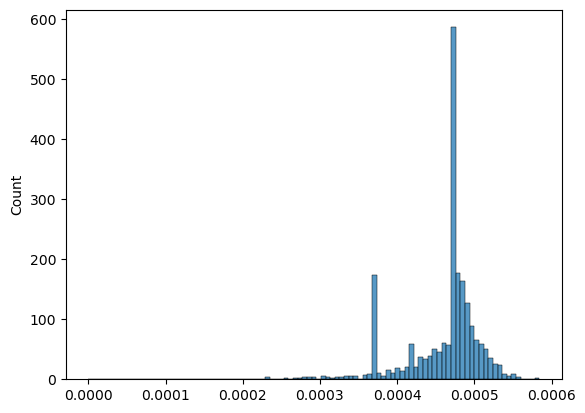

Index(['PKN3_rnaseq', 'SLC44A1_rnaseq', 'OXT_rnaseq', 'CAMKV_rnaseq',
       'CD86_rnaseq', 'MAPK3_rnaseq', 'MAP4K2_rnaseq', 'SEMA4G_rnaseq',
       'PAX3_rnaseq', 'EBI3_rnaseq'],
      dtype='object')

In [206]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_attn_weight_distribution(attn_weights: torch.Tensor):
    attn_weights = attn_weights.cpu().detach().numpy()
    attn_weights = attn_weights.flatten()
    sns.histplot(attn_weights)
    plt.show()
    
def get_most_important_features(attn_weights: torch.Tensor, blca: TCGADataset):
    attn_weights = attn_weights.cpu().detach().numpy()
    attn_weights = attn_weights.flatten()
    # get top 10 features
    top_10 = np.argsort(attn_weights)[-10:]
    # get feature names
    feature_names = blca.omic_df.columns
    top_10_features = feature_names[top_10]
    return top_10_features
    
plot_attn_weight_distribution(encoder.layers[0].attn_weights[0])
get_most_important_features(encoder.layers[0].attn_weights[0], blca)